# Maximum Independent Set (MIS)


In [2]:
# import necessary libraries
using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using PythonCall
plt = pyimport("matplotlib.pyplot");

## Setting up graph

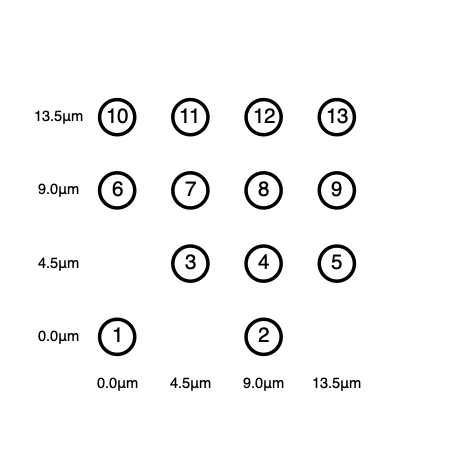

In [3]:
Random.seed!(2)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.2)

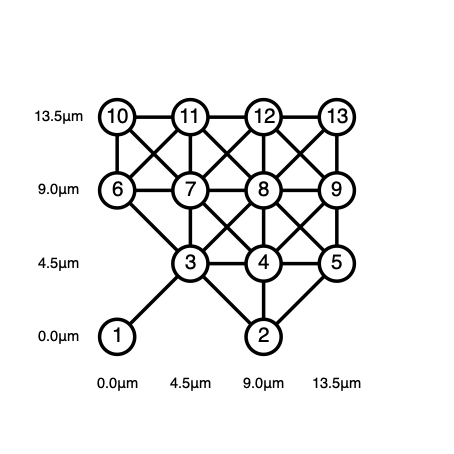

In [4]:
Bloqade.plot(atoms, blockade_radius = 7.5)

In [5]:
# the exact solution
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 26.0)ₜ

## The Adiabatic Approach

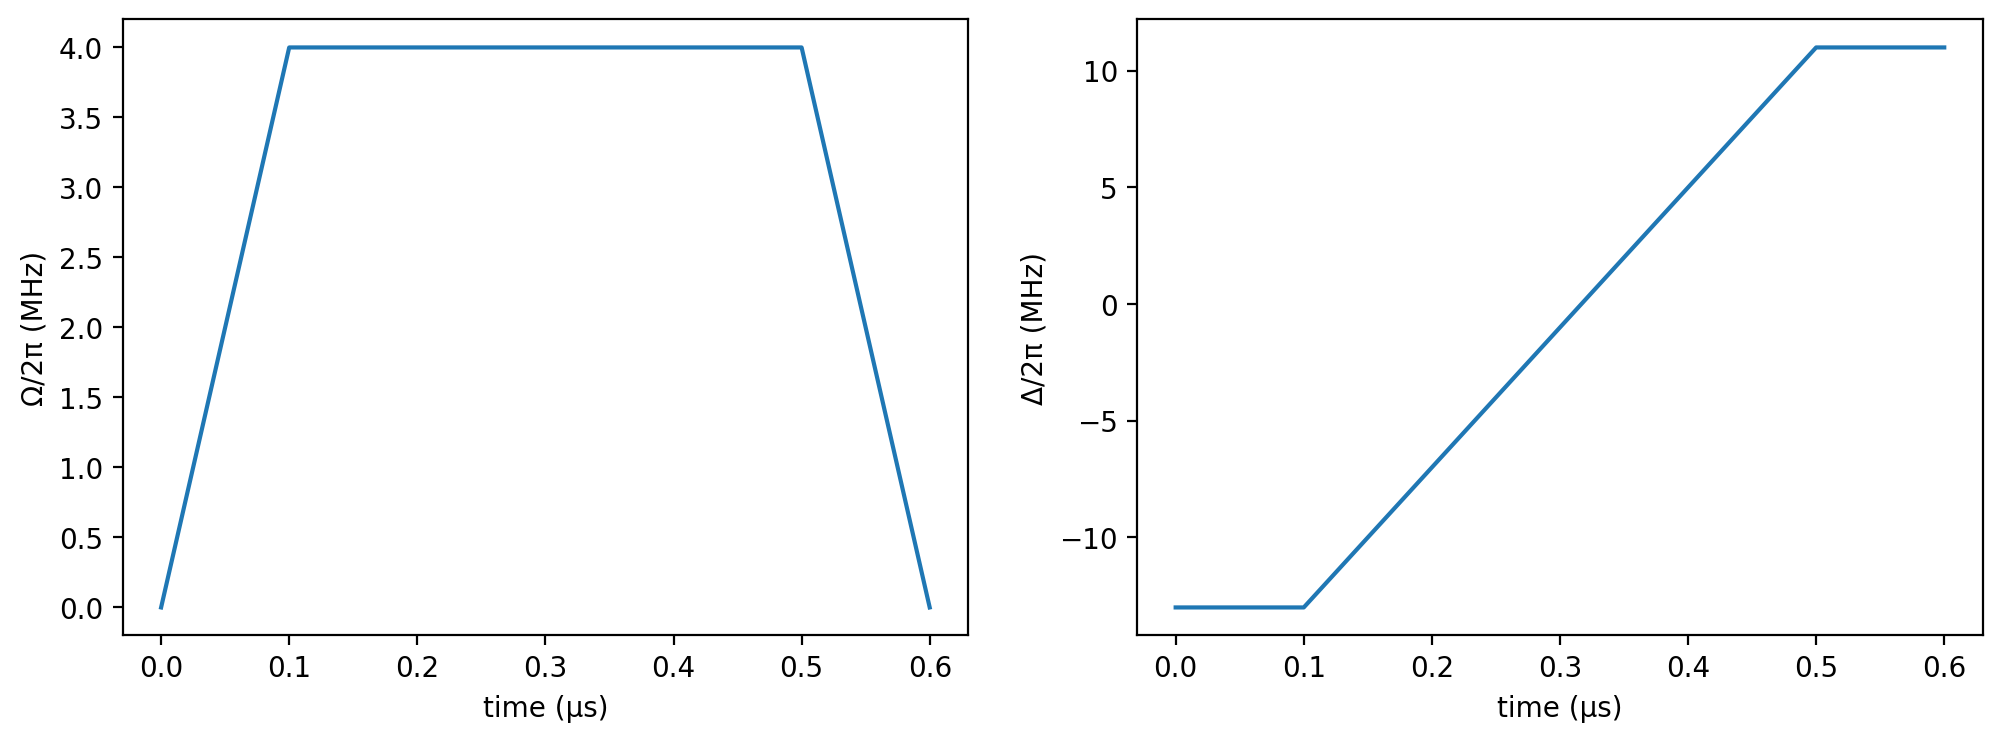

In [6]:
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [63]:
hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 1.688 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false


-4.1557282370321715

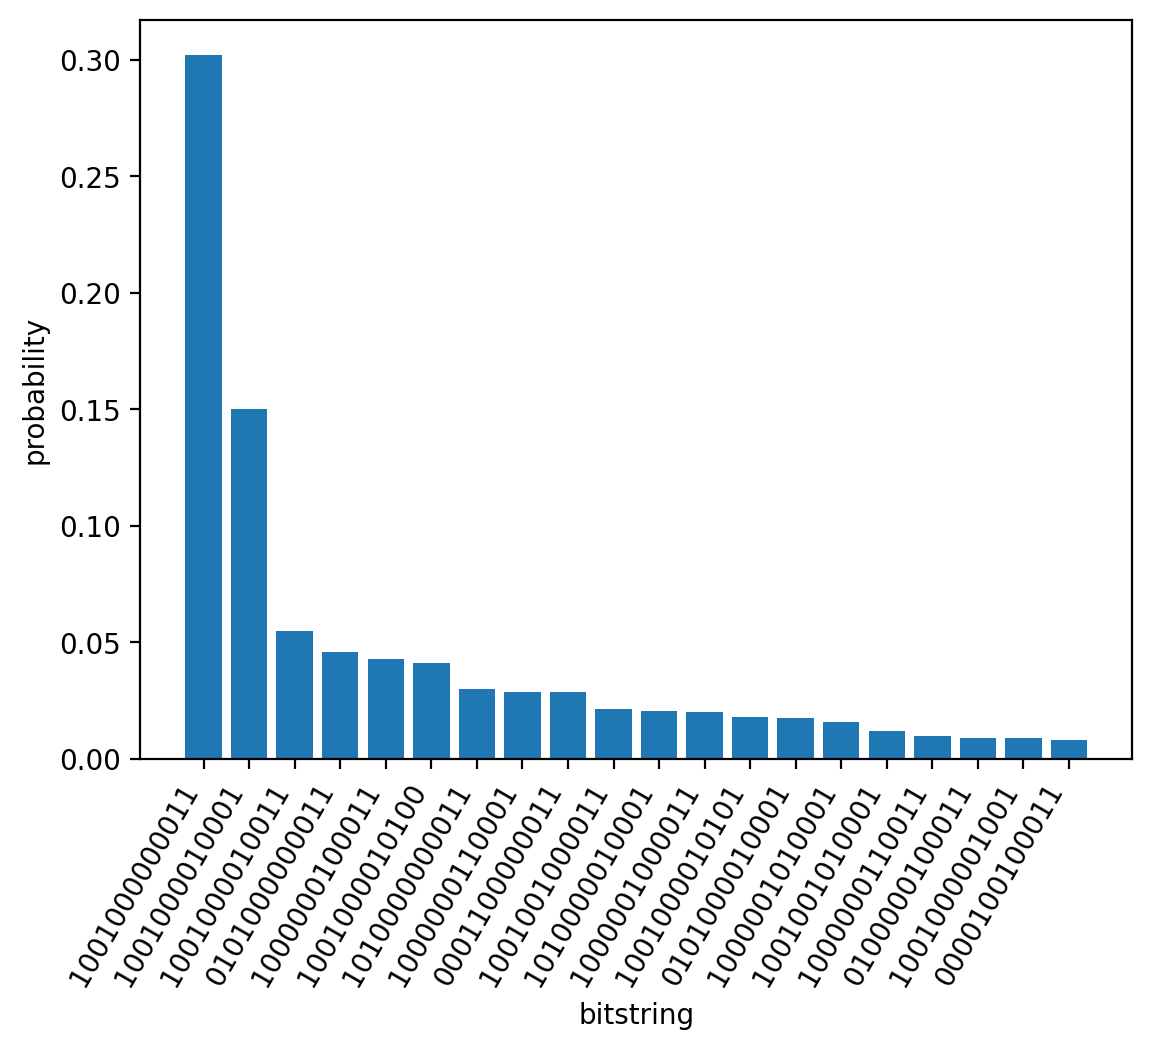

In [64]:
print(-rydberg_density_sum(prob.reg))
bitstring_hist(prob.reg; nlargest = 20)

In [65]:
best_bit_strings = most_probable(prob.reg, 2)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)

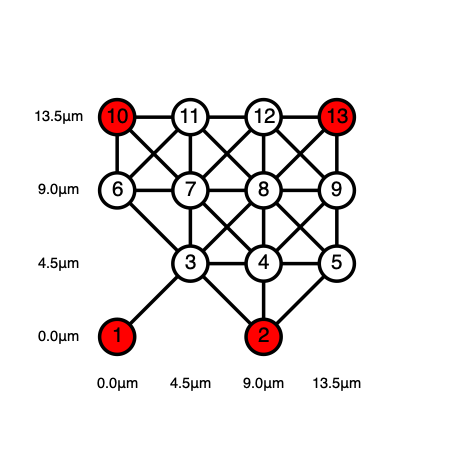

In [66]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

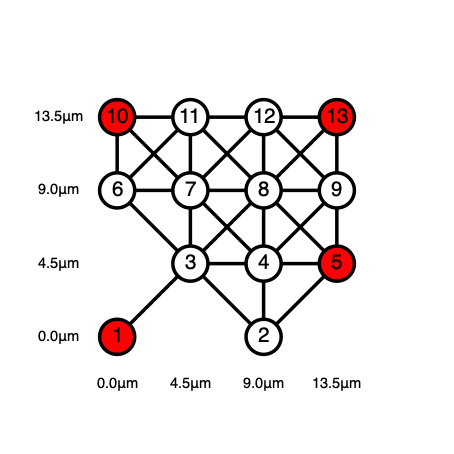

In [67]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

In [81]:
best5_bit_strings = most_probable(prob.reg, 26)
BloqadeMIS.is_independent_set.(best5_bit_strings, Ref(graph))

26-element BitVector:
 1
 1
 0
 1
 1
 1
 1
 1
 1
 0
 1
 1
 0
 1
 1
 0
 0
 1
 1
 1
 1
 0
 0
 0
 0
 0

Out of the top 26 most probable states, 10 of them are not maximum independent sets.

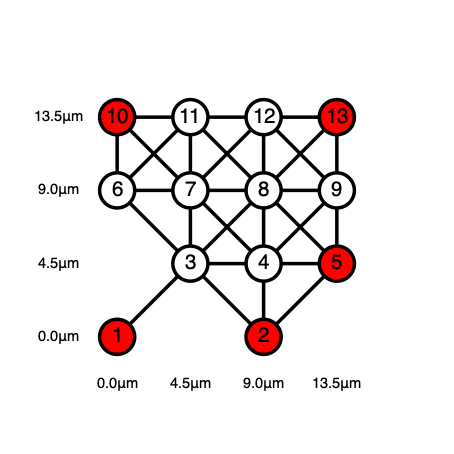

In [69]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best5_bit_strings[3]])

In [14]:
fixed = mis_postprocessing(best5_bit_strings[3], graph)
BloqadeMIS.is_independent_set(fixed, graph)

true

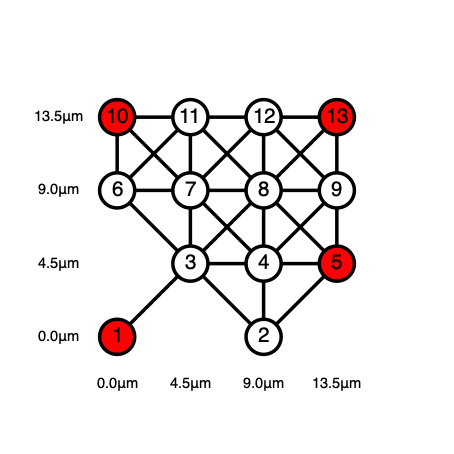

In [15]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in fixed])

The correction removed the extra bit (12).

## Solving with QAOA


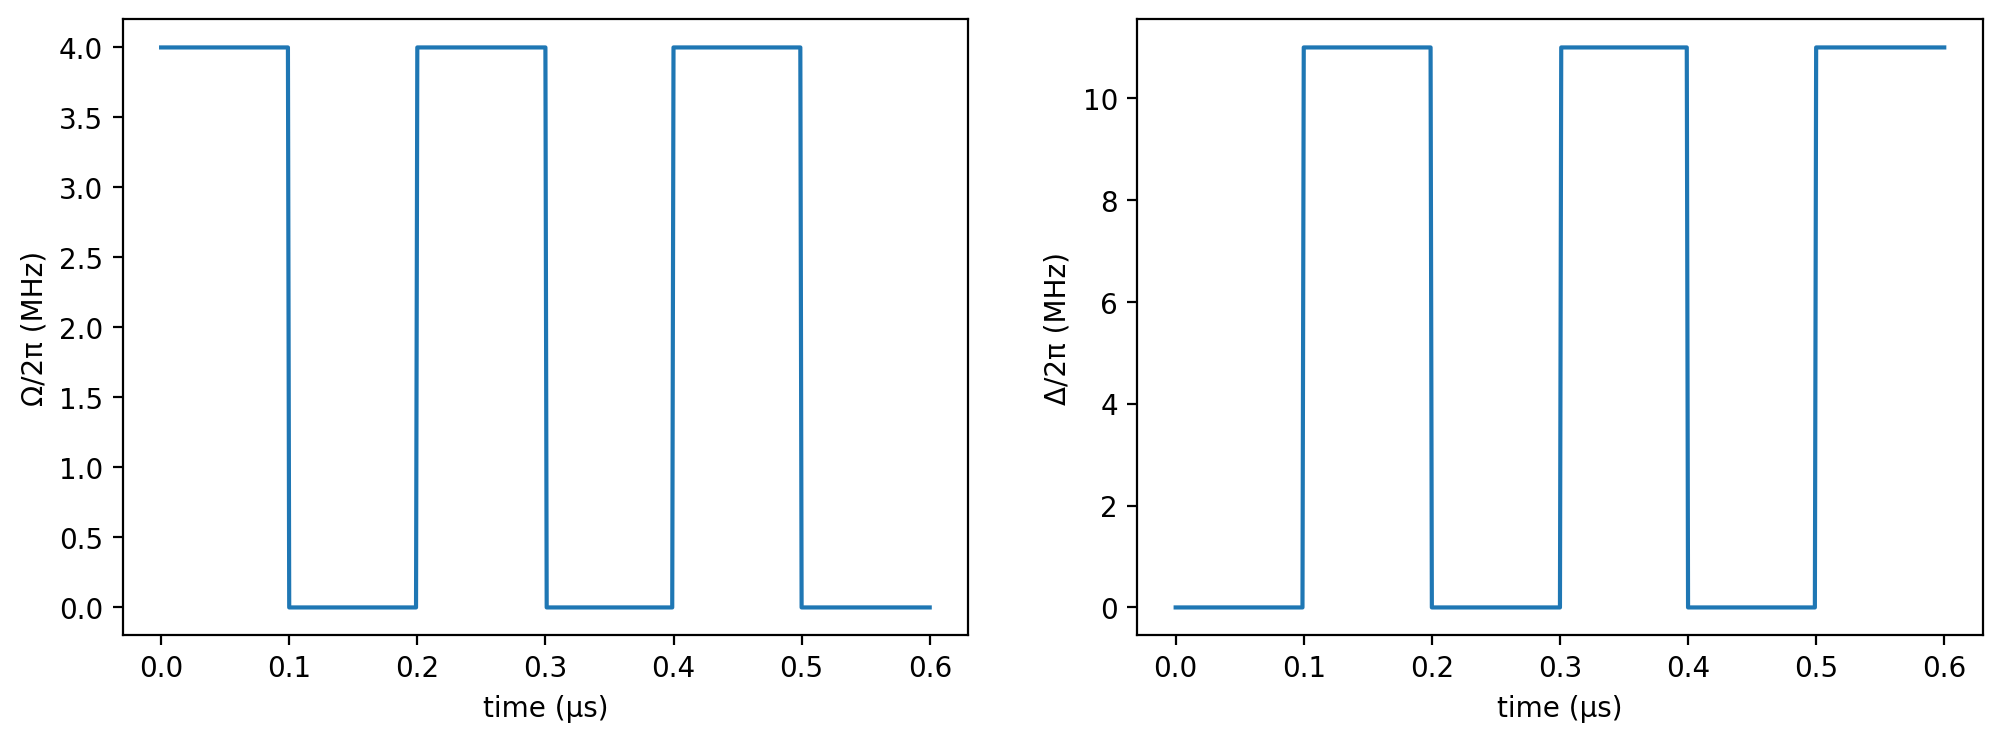

In [16]:
# example pulse

durations = fill(0.1, 6)
clocks = [0, cumsum(durations)...]
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 3))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 3))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig


In [20]:
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 4 * 2π
    Δ_end = 11 * 2π
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end


loss_piecewise_constant (generic function with 1 method)

In [54]:
durations = fill(0.1, 6)
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density

-2.562886912802683

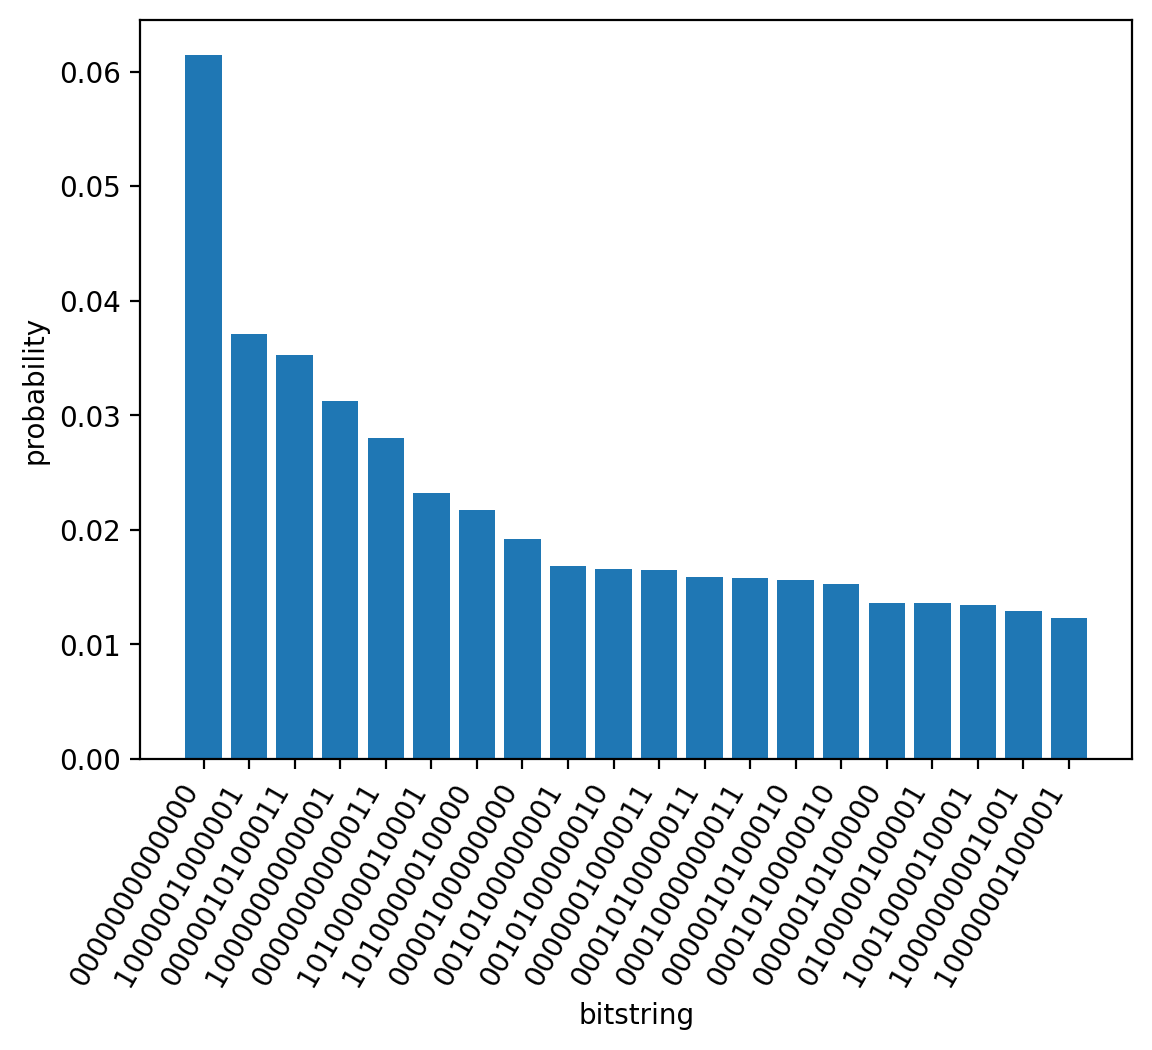

In [55]:
bitstring_hist(reg1; nlargest = 20)

In [56]:
# optimizing loss function
optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
rydberg_density_final

-3.096591026001217

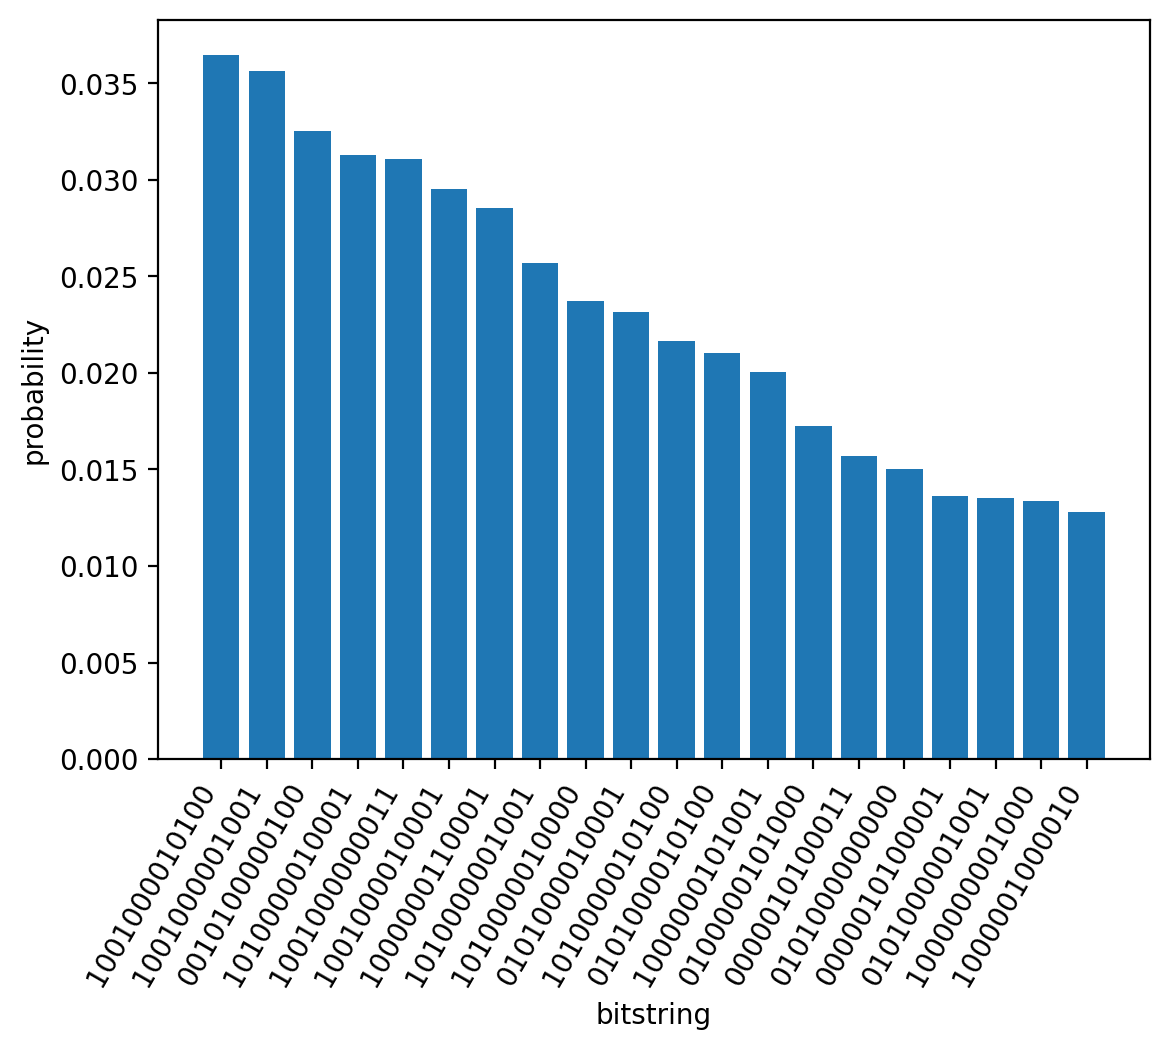

In [57]:
bitstring_hist(reg1_final; nlargest = 20)

In [61]:
# p = 4
durations = fill(0.1, 8)
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
print("Before optimization:"*string(rydberg_density)*"\n")

# optimizing loss function
optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
print("After optimization:"*string(rydberg_density_final))

Before optimization:-2.3982437376235133
After optimization:-3.217239153509958

Increasing the number of steps $p$ to 4 plus optimization improved the loss function.

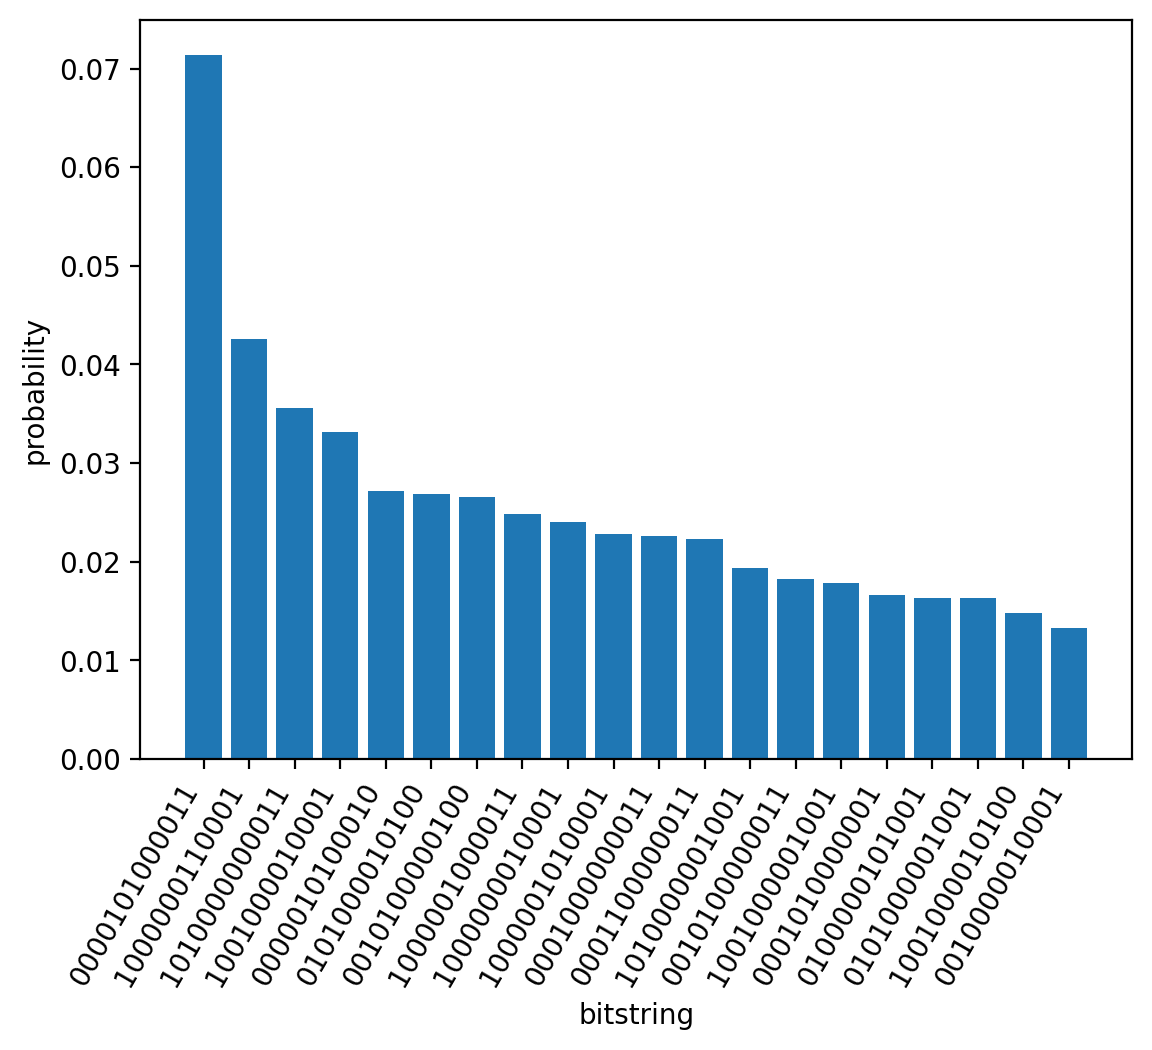

In [62]:
bitstring_hist(reg1_final; nlargest = 20)

## Smoothed Piecewise Pulse

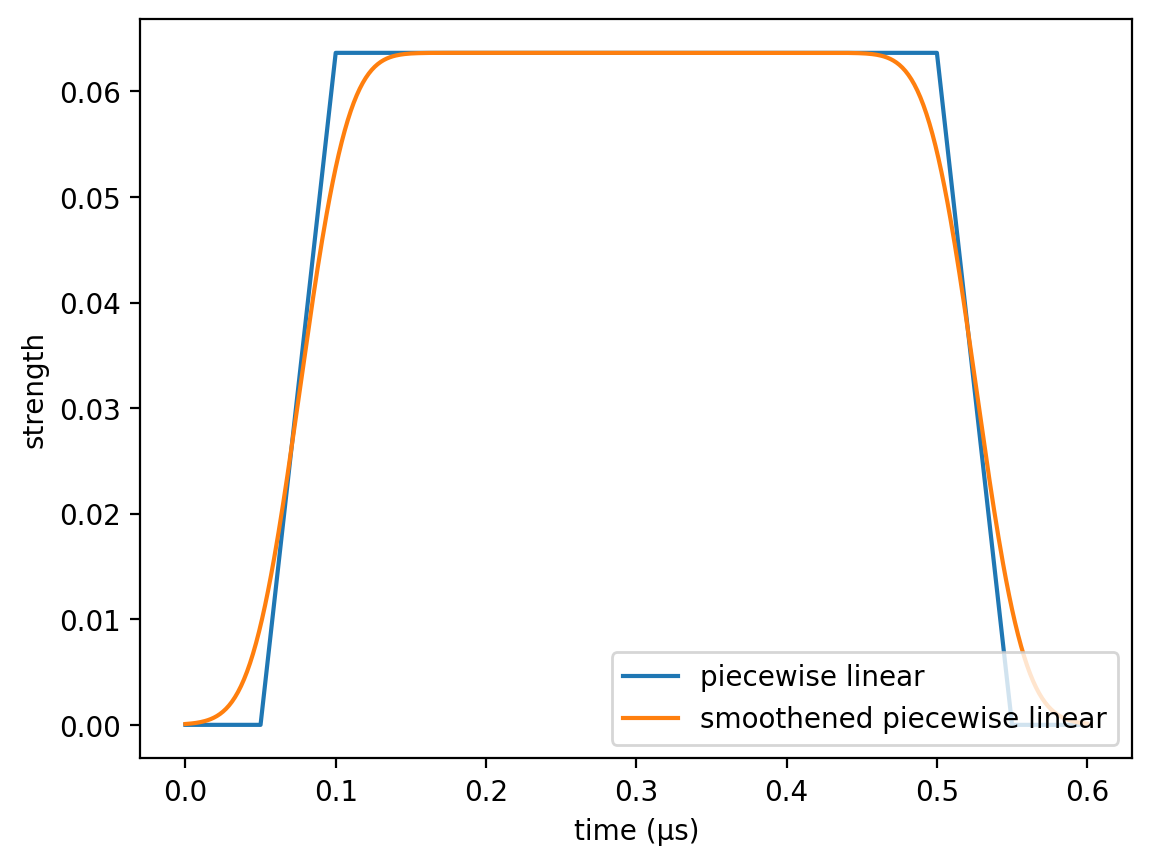

In [70]:
pulse_piecewise_linear = piecewise_linear(clocks = [0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = [0, 0, 0.4, 0.4, 0, 0]);
pulse_smooth = smooth(pulse_piecewise_linear; kernel_radius = 0.02);

fig, ax = plt.subplots()
Bloqade.plot!(ax, pulse_piecewise_linear)
Bloqade.plot!(ax, pulse_smooth)
ax.set_ylabel("strength")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig


In [71]:
# loss function with smoothed wave

function loss_piecewise_linear(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) == 3
    Ω_max = 4 * 2π
    Δ_start = -13 * 2π
    Δ_end = 11 * 2π
    Δ0 = 11 * 2π
    T_max = 0.6

    # the strength of the detunings at each step takes the optimizing x as their input
    Δs = smooth(
        piecewise_linear(
            clocks = T[0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
            values = T[Δ_start, Δ_start, Δ0*x[1], Δ0*x[2], Δ0*x[3], Δ_end, Δ_end],
        );
        kernel_radius = 0.02,
    )
    Ωs = smooth(
        piecewise_linear(clocks = T[0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = T[0, 0, Ω_max, Ω_max, 0, 0]);
        kernel_radius = 0.02,
    )

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)
    prob = SchrodingerProblem(zero_state(Complex{T}, subspace), T_max, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg, Δs
end

x0 = [0.1, 0.8, 0.8]; # initial point for the optimization


In [72]:
Δ_start = -13 * 2π
Δ_end = 11 * 2π
Δ0 = 11 * 2π
T_max = 0.6
Δ_initial = piecewise_linear(
    clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
    values = [Δ_start, Δ_start, Δ0 * x0[1], Δ0 * x0[2], Δ0 * x0[3], Δ_end, Δ_end],
)

rydberg_density, reg2, Δ_initial_smooth = loss_piecewise_linear(atoms, x0)
rydberg_density


-3.892595155083945

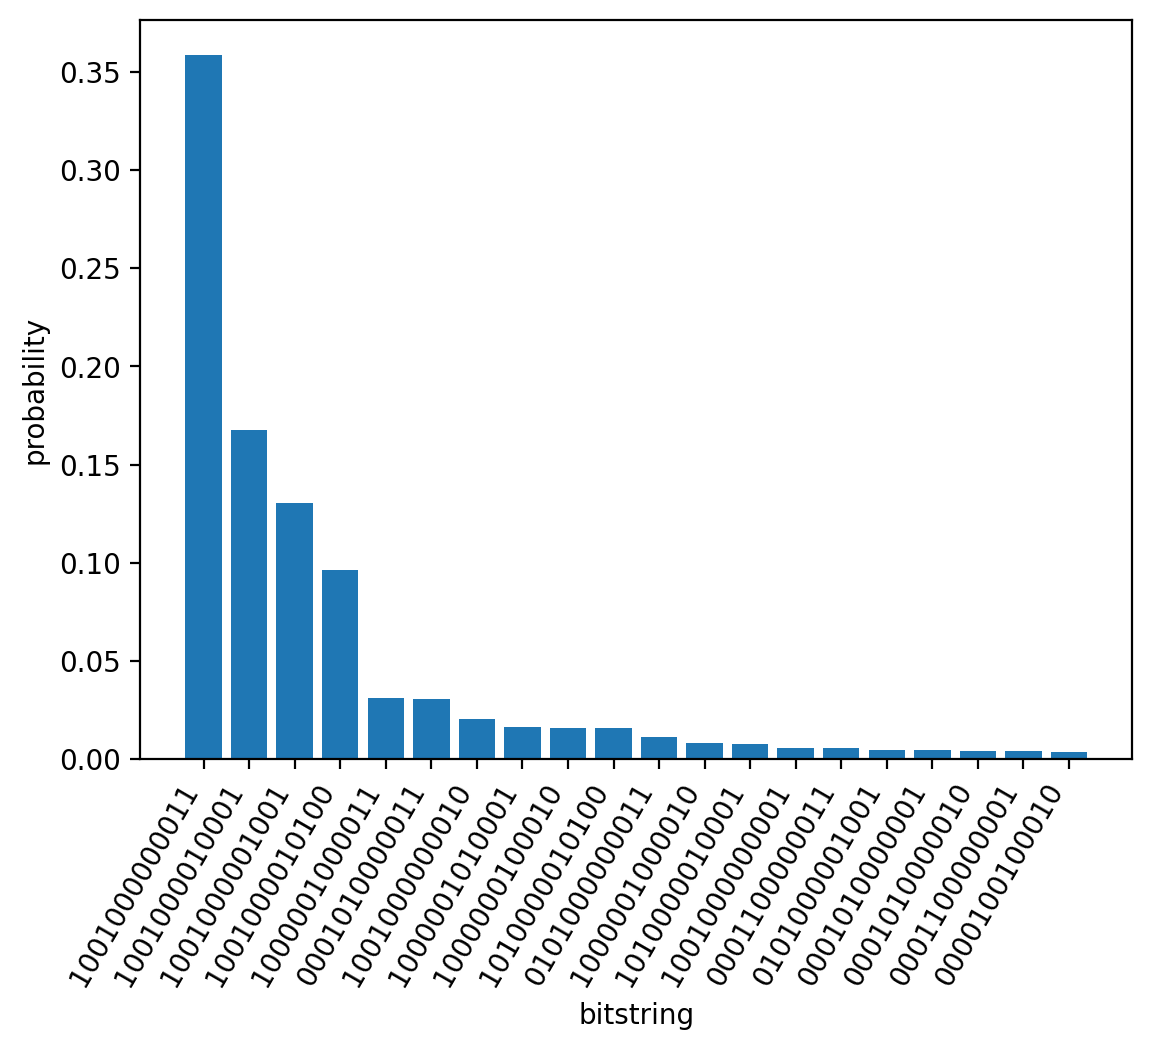

In [73]:
bitstring_hist(reg2; nlargest = 20)

In [74]:
# optimizing with the smoothed wave
optresult = Optim.optimize(x -> loss_piecewise_linear(atoms, x)[1], x0)

rydberg_density_final, reg_final, Δ_final = loss_piecewise_linear(atoms, optresult.minimizer)
rydberg_density_final


-3.978139446307858

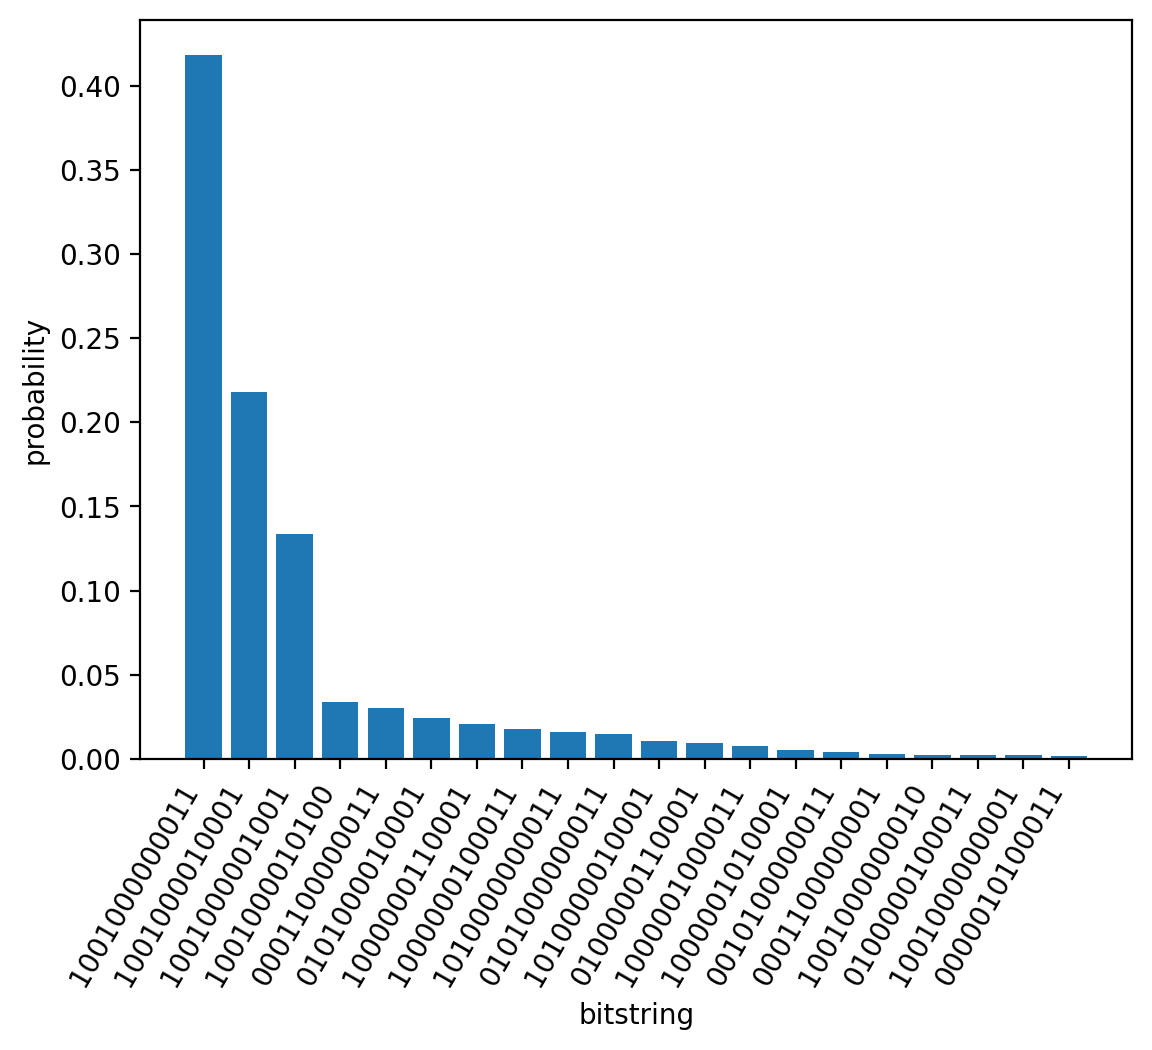

In [75]:
bitstring_hist(reg_final; nlargest = 20)

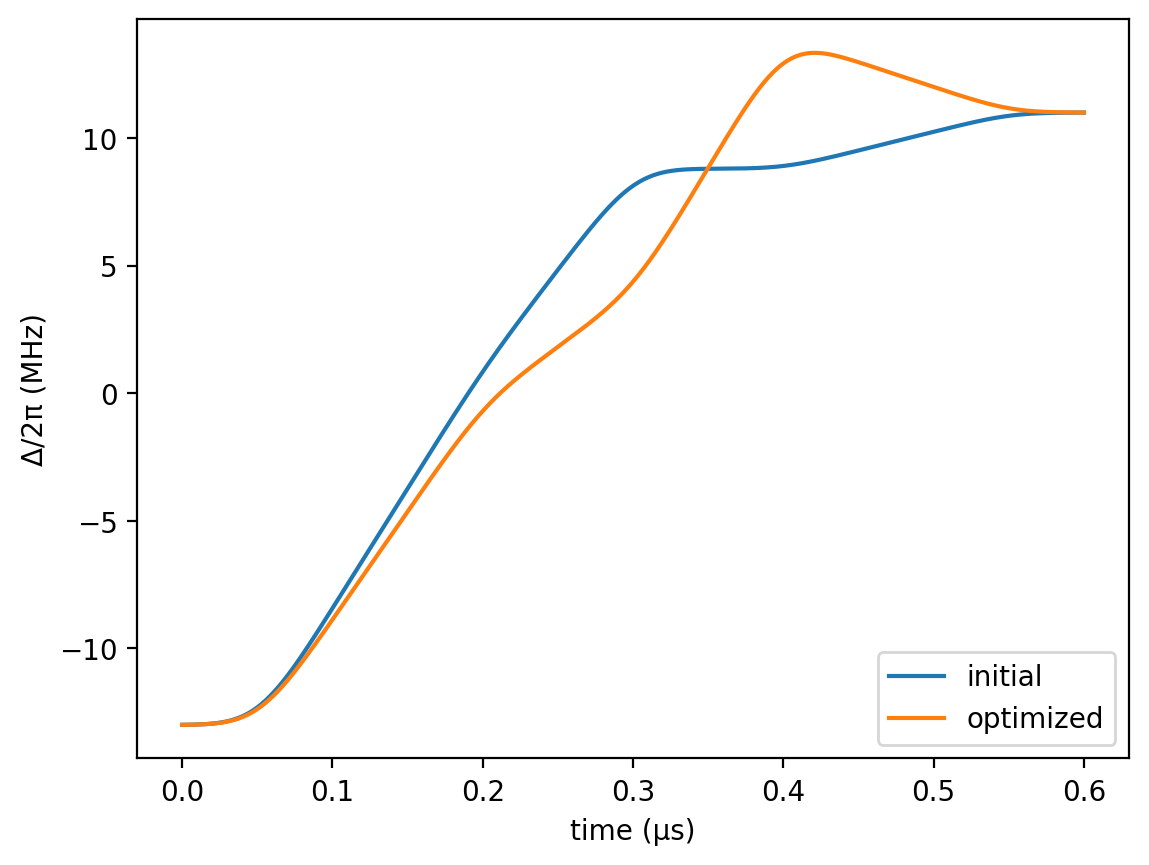

In [76]:
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial_smooth)
Bloqade.plot!(ax, Δ_final)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["initial", "optimized"], loc = "lower right")
fig

In [79]:
top_bit_strings = most_probable(reg_final, 26)
BloqadeMIS.is_independent_set.(top_bit_strings, Ref(graph))

26-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

With optimized smoothed pulses, we obtain all 26 maximum independent sets.